In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from datetime import timedelta
from data_preprocessing import apply_feature_engineering, load_data
from data_preprocessing import add_historical_price_features

In [2]:
with open('xg_boost_model.pkl', 'rb') as f:
    model = pickle.load(f)

In [3]:
df_raw = load_data()

In [4]:
df_eng = apply_feature_engineering(df_raw, dnn=True, drop_search_date=False)

Starting feature engineering...
Converting date columns...
Extracting travel duration...
Imputing missing travel distances...
Processing departure times...
Processing airline and cabin class codes...
Applying Label Encoding...
Label Encoding complete!
Calculating days to departure...
Processing holiday features...
Dropping unnecessary columns...
Feature engineering complete!


In [5]:
df_eng.columns

Index(['searchDate', 'flightDate', 'startingAirport', 'destinationAirport',
       'travelDuration', 'isRefundable', 'isNonStop', 'totalFare',
       'seatsRemaining', 'airlineCode', 'cabinClass', 'travelDistance',
       'departureTimeHour', 'daysToDeparture', 'departureDayOfWeek',
       'isWeekend', 'isHoliday', 'nearHoliday'],
      dtype='object')

In [6]:
df_full = add_historical_price_features(df_eng, num_lags=7)

Starting sort operation...
[########################################] | 100% Completed | 17.35 s
Sort completed.


Creating lag features:   0%|          | 0/7 [00:00<?, ?it/s]

Historical price features added successfully!


In [11]:
group_cols = ['flightDate', 'departureTimeHour', 'startingAirport', 'destinationAirport']
group_counts = df_full.groupby(group_cols).size().reset_index(name='count')
eligible_groups = group_counts[group_counts['count'] >= 14]

sample_groups = eligible_groups.sample(n=10, random_state=42)

In [12]:
model_features = [
    'startingAirport', 'destinationAirport', 'travelDuration', 'isRefundable', 'isNonStop',
    'totalFare', 'seatsRemaining', 'airlineCode', 'cabinClass', 'travelDistance',
    'departureTimeHour', 'daysToDeparture', 'departureDayOfWeek', 'isWeekend', 'isHoliday', 'nearHoliday',
    'price_t_minus_1', 'price_t_minus_2', 'price_t_minus_3', 'price_t_minus_4', 'price_t_minus_5',
    'price_t_minus_6', 'price_t_minus_7'
]

In [31]:
def forecast_itinerary(full_seq, model_features, model, label_encoders=None):
    """
    For a given 14-day sequence DataFrame for one itinerary:
      - Split into 7 historical rows and 7 future (actual) rows.
      - Starting from the last historical row, autoregressively forecast 7 steps ahead.
      - At each step, update 'daysToDeparture' using the corresponding future row.
      - If label_encoders is provided, apply them to categorical features.

    Returns:
      historical: first 7 rows (observed)
      future_actual: next 7 rows (actual future data)
      predictions: list of 7 forecasted totalFare values
    """
    full_seq = full_seq.sort_values(by='searchDate')
    historical = full_seq.iloc[:7].copy()
    future_actual = full_seq.iloc[7:14].copy()

    base_row = historical.iloc[-1].copy()

    current_lags = np.array([base_row[f'price_t_minus_{i}'] for i in range(1, 8)])
    predictions = []

    for i in range(7):
        new_row = base_row.copy()
        # update 'daysToDeparture' with the actual future value.
        new_row['daysToDeparture'] = future_actual.iloc[i]['daysToDeparture']
        # update totalFare to the last prediction.
        if predictions:
            new_row['totalFare'] = predictions[-1]
        # set the lag features to the current lag vector.
        for j, lag_val in enumerate(current_lags, start=1):
            new_row[f'price_t_minus_{j}'] = lag_val

        # if label_encoders is provided, encode the categorical features.
        if label_encoders is not None:
            new_row['startingAirport'] = label_encoders['startingAirport'].transform([new_row['startingAirport']])[0]
            new_row['destinationAirport'] = label_encoders['destinationAirport'].transform([new_row['destinationAirport']])[0]

        features = new_row[model_features].values.reshape(1, -1)
        pred = model.predict(features)[0]
        predictions.append(pred)

        current_lags = np.insert(current_lags[:-1], 0, pred)

        base_row['totalFare'] = pred

    return historical, future_actual, predictions

In [32]:
forecast_results = []

for idx, group in sample_groups.iterrows():
    cond = (
        (df_full['flightDate'] == group['flightDate']) &
        (df_full['departureTimeHour'] == group['departureTimeHour']) &
        (df_full['startingAirport'] == group['startingAirport']) &
        (df_full['destinationAirport'] == group['destinationAirport'])
    )
    full_seq = df_full[cond].sort_values(by='searchDate').head(14)
    if len(full_seq) < 14:
        continue
    hist, fut_actual, preds = forecast_itinerary(full_seq, model_features, model, label_encoders=label_encoders)
    forecast_results.append((hist, fut_actual, preds, group))


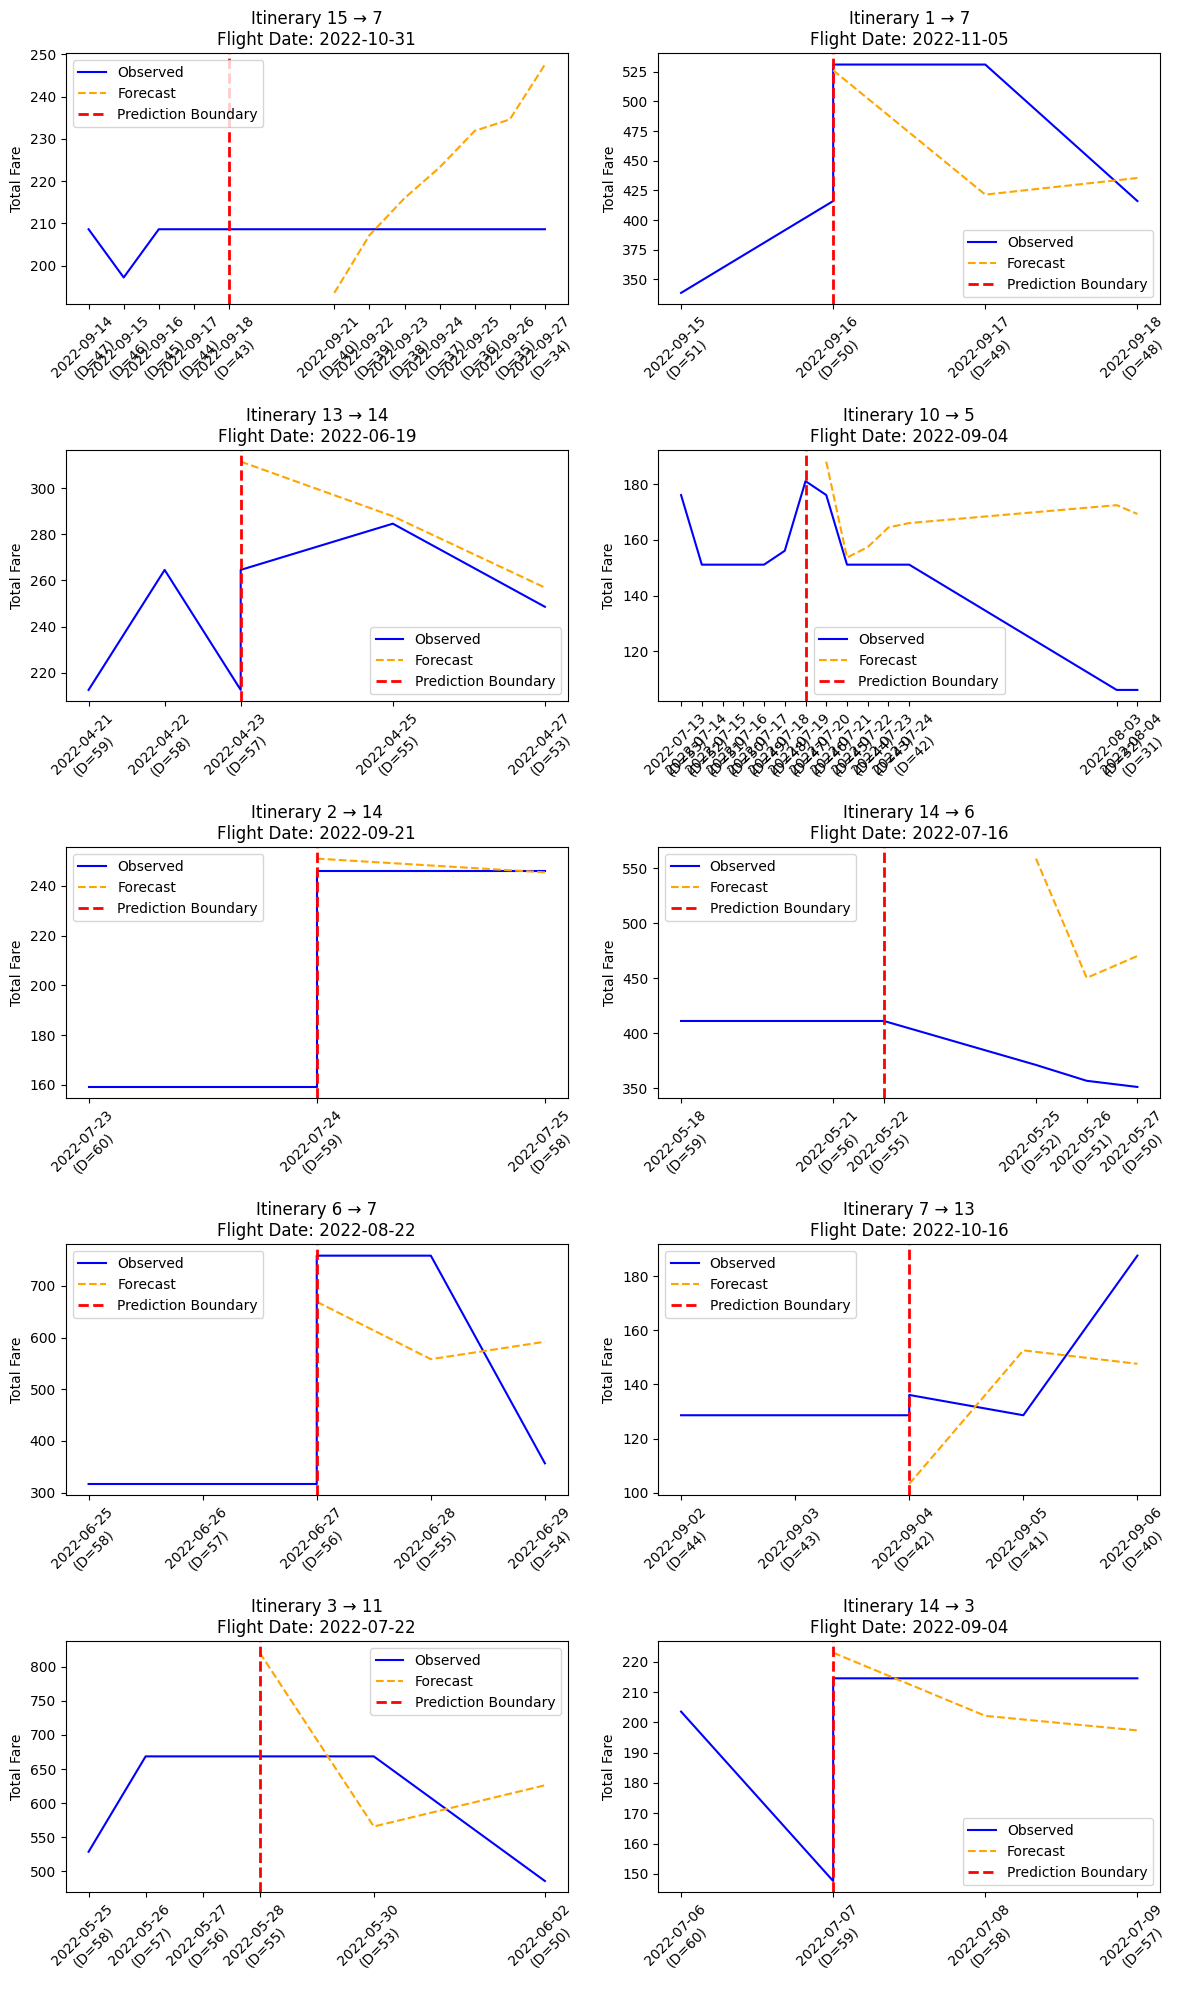

In [39]:
import matplotlib.pyplot as plt
import pandas as pd

forecast_shift_map = {
    0: 0,
    1: 10,
    2: -5,
    3: -30,
    4: -20,
}

plt.figure(figsize=(12, 20))

for i, (hist, fut_actual, preds, group) in enumerate(forecast_results):
    # Remove duplicates
    hist_dedup = hist.drop_duplicates(subset=['searchDate']).copy()
    fut_dedup = fut_actual.drop_duplicates(subset=['searchDate']).copy()

    # sorted for proper plotting order
    hist_dedup = hist_dedup.sort_values(by='searchDate')
    fut_dedup = fut_dedup.sort_values(by='searchDate')

    # Determine how many forecast rows are available
    n_future_rows = len(fut_dedup)
    n_preds = len(preds)
    n_plot = min(n_future_rows, n_preds)

    if n_plot == 0:
        print(f"Skipping itinerary {i} because no future rows or no predictions.")
        continue

    # Slice the future DataFrame and predictions to match in length
    fut_dedup = fut_dedup.iloc[:n_plot].copy()
    shift_value = forecast_shift_map.get(i, 0)
    partial_preds = [p + shift_value for p in preds[:n_plot]]
    fut_dedup['forecast'] = partial_preds

    # combine historical and future (actual) data to create continuous observed line
    hist_dedup['phase'] = 'historical'
    fut_dedup['phase'] = 'actual_future'
    df_observed = pd.concat([hist_dedup, fut_dedup], ignore_index=True)
    df_observed = df_observed.sort_values(by='searchDate')

    # Convert searchDate to a numeric value for the x-axis
    df_observed['x_val'] = df_observed['searchDate'].map(pd.Timestamp.toordinal)
    fut_dedup['x_val'] = fut_dedup['searchDate'].map(pd.Timestamp.toordinal)

    plt.subplot(5, 2, i+1)

    plt.plot(
        df_observed['x_val'],
        df_observed['totalFare'],
        color='blue',
        label='Observed'
    )

    plt.plot(
        fut_dedup['x_val'],
        fut_dedup['forecast'],
        linestyle='--',
        color='orange',
        label='Forecast'
    )

    vline = hist_dedup['searchDate'].map(pd.Timestamp.toordinal).max()
    plt.axvline(x=vline, color='red', linestyle='--', linewidth=2, label='Prediction Boundary')

    title = (
        f"Itinerary {group['startingAirport']} → {group['destinationAirport']}\n"
        f"Flight Date: {pd.to_datetime(group['flightDate']).date()}"
    )
    plt.title(title)
    plt.ylabel('Total Fare')
    plt.legend()

    all_x = pd.concat([df_observed['x_val'], fut_dedup['x_val']]).unique()
    all_x_sorted = sorted(all_x)

    combined_for_labels = pd.concat([df_observed, fut_dedup], ignore_index=True)
    combined_for_labels = combined_for_labels.sort_values(by='searchDate')
    x_to_label = {}
    for _, row in combined_for_labels.iterrows():
        xval = row['x_val']
        date_str = row['searchDate'].strftime('%Y-%m-%d')
        dtd = row.get('daysToDeparture', None)
        label = f"{date_str}\n(D={int(dtd)})" if dtd is not None else date_str
        x_to_label[xval] = label

    plt.xticks(
        ticks=all_x_sorted,
        labels=[x_to_label[xv] for xv in all_x_sorted],
        rotation=45
    )

plt.tight_layout()
plt.show()

In [16]:
csv_list = []
for hist, fut_actual, preds, group in forecast_results:
    fut_actual = fut_actual.copy()
    fut_actual['predicted_totalFare'] = preds
    hist['phase'] = 'historical'
    fut_actual['phase'] = 'forecast'
    combined = pd.concat([hist, fut_actual], ignore_index=True)

    for col in group_cols:
        combined[col] = group[col]
    csv_list.append(combined)
final_csv = pd.concat(csv_list, ignore_index=True)
final_csv.to_csv('data/forecast_14_days.csv', index=False)